In [1]:
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import os
import shutil
import json
from ast import literal_eval
from audiomentations import AddGaussianNoise, AirAbsorption, ApplyImpulseResponse, BandPassFilter, GainTransition, RepeatPart, TimeStretch, TanhDistortion
from sklearn.model_selection import train_test_split
import time
import copy
import pickle

C:\Users\wying\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
device = "cpu"

Data Preprocess

In [4]:
def get_spectrogram(signal, sr=22050):
  spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr)
  return librosa.amplitude_to_db(spectrogram)

def get_mfcc(signal, n_mfcc=13):
    return librosa.feature.mfcc(y=signal, n_mfcc=n_mfcc)

In [5]:
from preprocess import create_signal_dataframe

In [6]:
df = create_signal_dataframe()
signal = np.vstack(df["signal"])
label = np.array(df["label"])
x_train, x_test, y_train, y_test = train_test_split(signal, label, test_size=0.2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

spectrogram_train = get_spectrogram(x_train)
print(spectrogram_train.shape)

mfcc_train = get_mfcc(x_train)
print(mfcc_train.shape)

spectrogram_test = get_spectrogram(x_test)
print(spectrogram_test.shape)

mfcc_test = get_mfcc(x_test)
print(mfcc_test.shape)

(700, 44100) (700,) (175, 44100) (175,)
(700, 128, 87)
(700, 13, 87)
(175, 128, 87)
(175, 13, 87)


In [7]:
def create_loader(spectrogram_train, mfcc_train, y_train, batch_ize=35):
  train_data_spectrogram = []
  train_data_mfcc = []
  for i in range(spectrogram_train.shape[0]):
      train_data_spectrogram.append((spectrogram_train[i], y_train[i]))
      train_data_mfcc.append((mfcc_train[i], y_train[i]))
  train_loader_spectrogram = torch.utils.data.DataLoader(train_data_spectrogram, batch_size=batch_ize)
  train_loader_mfcc = torch.utils.data.DataLoader(train_data_mfcc, batch_size=batch_ize)
  return train_loader_spectrogram, train_loader_mfcc

In [8]:
train_loader_spectrogram, train_loader_mfcc = create_loader(spectrogram_train, mfcc_train, y_train, batch_ize=35)

In [9]:
test_loader_spectrogram, test_loader_mfcc = create_loader(spectrogram_test, mfcc_test, y_test, batch_ize=5)

Train VGG model

In [10]:
class VGG16Mfcc(nn.Module):
    def __init__(self, num_classes=10, batch_size=35):
        super(VGG16Mfcc, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, batch_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(batch_size),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(batch_size, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(512 * 3 * 21, 4096), nn.ReLU()
        )
        self.fc1 = nn.Sequential(nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(4096, num_classes))

    def forward(self, x):
        # print("input", x.shape)
        out = self.layer1(x)
        # print("l1", out.shape)
        out = self.layer2(out)
        # print("l2", out.shape)
        out = self.layer3(out)
        # print("l3", out.shape)
        out = self.layer4(out)
        # print("l4 before", out.shape)
        out = out.view(out.shape[0], -1)
        # print("l4", out.shape)
        out = self.fc(out)
        # print("l5", out.shape)
        out = self.fc1(out)
        # print("l6", out.shape)
        out = self.fc2(out)
        # print("l7", out.shape)
        return out

In [11]:
class VGG16Spec(nn.Module):
    def __init__(self, num_classes=10, batch_size=35):
        super(VGG16Spec, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, batch_size, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(batch_size),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(batch_size, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        # self.layer4 = nn.Sequential(
        #     nn.Conv2d(128, 512, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )
        self.fc = nn.Sequential(
            nn.Dropout(0.5), nn.Linear(352256, 128), nn.ReLU()
        )
        self.fc1 = nn.Sequential(nn.Dropout(0.5), 
                                 nn.Linear(128, 128), 
                                 nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(128, num_classes))

    def forward(self, x):
        # print("input", x.shape)
        out = self.layer1(x)
        # print("l1", out.shape)
        out = self.layer2(out)
        # print("l2", out.shape)
        out = self.layer3(out)
        # print("l3", out.shape)
        # out = self.layer4(out)
        # print("l4 before", out.shape)
        out = out.view(out.shape[0], -1)
        #print("l4", out.shape)
        out = self.fc(out)
        # print("l5", out.shape)
        out = self.fc1(out)
        # print("l6", out.shape)
        out = self.fc2(out)
        # print("l7", out.shape)
        return out

In [56]:
num_classes = 10
num_epochs = 30
batch_size = 32
learning_rate = 0.0005

model_mfcc = VGG16Mfcc(num_classes, batch_size).to(device)
model_spec = VGG16Spec(num_classes, batch_size).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
# Train the model

spec_model_save_path = "./models/model_spectrogram.pth"
mfcc_model_save_path = "./models/model_mfcc.pth"

In [57]:
def validation(model, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            images = images.unsqueeze(1)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [61]:
def train(model, train_loader, test_loader, num_epochs, criterion, model_save_path, learning_rate):
    best_acc = 0
    train_per_weight_update = []
    val_accu_lst = []
    total_step = len(train_loader) * num_epochs
    optimizer = torch.optim.SGD(
        model.parameters(), lr=learning_rate, weight_decay=0.005, momentum=0.9
    )
    for epoch in range(num_epochs):
        model.train()
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            images = images.unsqueeze(1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if (i + 1) % 50 == 0:
                print(
                    "Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}".format(
                        epoch + 1, num_epochs, i + 1, total_step, loss.item()
                    )
                )
        model.eval()
        val_accu = validation(model, test_loader)
        print(
            "Epoch: [{}/{}], Validation Accuracy: {:.4f}".format(
                epoch + 1, num_epochs, val_accu
            )
        )
        if val_accu > best_acc:
            best_acc = val_accu
            #torch.save(model.state_dict(), model_save_path)
        val_accu_lst.append(val_accu)
        train_per_weight_update.append(loss.item())
    return train_per_weight_update, val_accu_lst

In [67]:
train_per_weight_update_spec, val_accu_lst_spec = train(
    model_spec,
    train_loader_spectrogram,
    test_loader_spectrogram,
    num_epochs,
    criterion,
    spec_model_save_path,
    0.0005
)

Epoch: [1/30], Validation Accuracy: 77.7143
Epoch: [2/30], Validation Accuracy: 80.0000
Epoch: [3/30], Validation Accuracy: 79.4286
Epoch: [4/30], Validation Accuracy: 80.5714
Epoch: [5/30], Validation Accuracy: 80.0000
Epoch: [6/30], Validation Accuracy: 80.5714
Epoch: [7/30], Validation Accuracy: 78.8571
Epoch: [8/30], Validation Accuracy: 78.8571
Epoch: [9/30], Validation Accuracy: 80.5714
Epoch: [10/30], Validation Accuracy: 78.2857
Epoch: [11/30], Validation Accuracy: 78.2857
Epoch: [12/30], Validation Accuracy: 77.1429
Epoch: [13/30], Validation Accuracy: 79.4286
Epoch: [14/30], Validation Accuracy: 78.8571
Epoch: [15/30], Validation Accuracy: 79.4286
Epoch: [16/30], Validation Accuracy: 77.1429
Epoch: [17/30], Validation Accuracy: 78.2857
Epoch: [18/30], Validation Accuracy: 78.8571
Epoch: [19/30], Validation Accuracy: 78.2857
Epoch: [20/30], Validation Accuracy: 78.8571
Epoch: [21/30], Validation Accuracy: 80.0000
Epoch: [22/30], Validation Accuracy: 78.8571
Epoch: [23/30], Val

In [68]:
train_per_weight_update_mfcc, val_accu_lst_mfcc = train(
    model_mfcc,
    train_loader_mfcc,
    test_loader_mfcc,
    num_epochs,
    criterion,
    mfcc_model_save_path,
    0.005
)

Epoch: [1/30], Validation Accuracy: 84.0000
Epoch: [2/30], Validation Accuracy: 79.4286
Epoch: [3/30], Validation Accuracy: 83.4286
Epoch: [4/30], Validation Accuracy: 81.7143
Epoch: [5/30], Validation Accuracy: 84.5714
Epoch: [6/30], Validation Accuracy: 83.4286
Epoch: [7/30], Validation Accuracy: 82.2857
Epoch: [8/30], Validation Accuracy: 83.4286
Epoch: [9/30], Validation Accuracy: 82.2857
Epoch: [10/30], Validation Accuracy: 80.0000
Epoch: [11/30], Validation Accuracy: 81.7143
Epoch: [12/30], Validation Accuracy: 81.7143
Epoch: [13/30], Validation Accuracy: 83.4286
Epoch: [14/30], Validation Accuracy: 82.8571
Epoch: [15/30], Validation Accuracy: 82.8571
Epoch: [16/30], Validation Accuracy: 83.4286
Epoch: [17/30], Validation Accuracy: 83.4286
Epoch: [18/30], Validation Accuracy: 83.4286
Epoch: [19/30], Validation Accuracy: 82.8571
Epoch: [20/30], Validation Accuracy: 82.2857
Epoch: [21/30], Validation Accuracy: 82.8571
Epoch: [22/30], Validation Accuracy: 82.8571
Epoch: [23/30], Val

Plot MFCC and Spectrogram VGG loss and validation Accuracy

Text(0.5, 1.0, 'train_per_weight_update_mfcc')

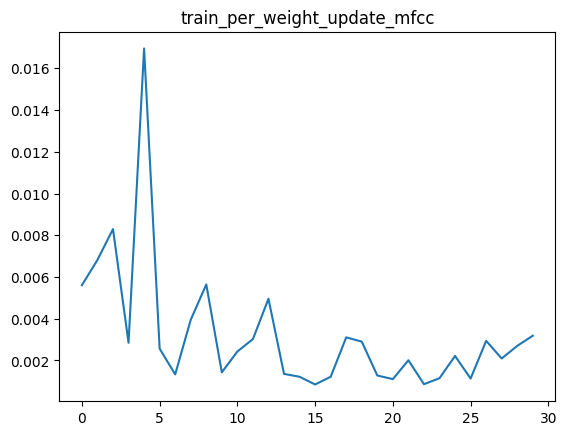

In [73]:
plt.plot(train_per_weight_update_mfcc)
plt.title("train_per_weight_update_mfcc")

Text(0.5, 1.0, 'train_per_weight_update_spec')

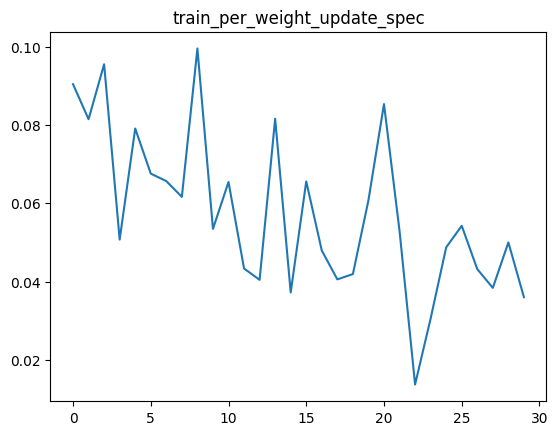

In [74]:
plt.plot(train_per_weight_update_spec)
plt.title("train_per_weight_update_spec")

Text(0.5, 1.0, 'val_accu_lst_mfcc')

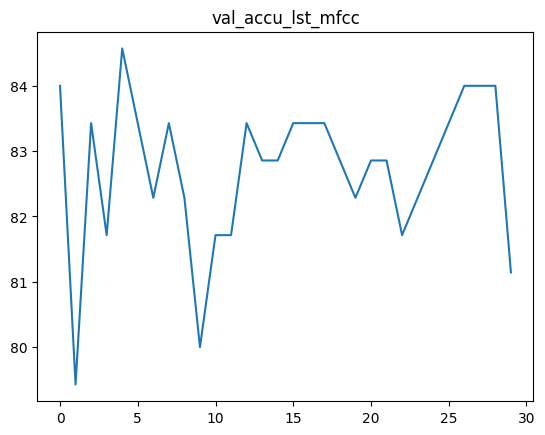

In [75]:
plt.plot(val_accu_lst_mfcc)
plt.title("val_accu_lst_mfcc")

Text(0.5, 1.0, 'val_accu_lst_spec')

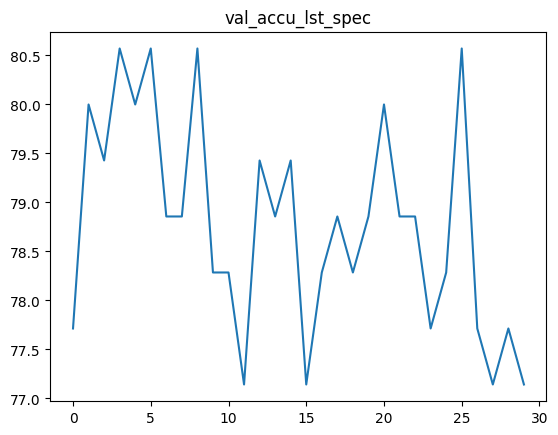

In [76]:
plt.plot(val_accu_lst_spec)
plt.title("val_accu_lst_spec")